# TODO: 
## Must
- [x] Rename columns for easier handling
- [ ] Implement cross validation training technique
- [ ] Implement learning curve plot for different model complexities
- [ ] Plot ROC curves for different models for comparisson
- [ ] Implement ensemble methods for classification

## Should
- [ ] Keep training and testing accuracy scores while training for plotting purposes

## Nice to do
- [ ] Use sklearn's 1 hot encoder
- [ ] Use spell checking to correct genres
- [ ] More classification models

# 1. Προετοιμασία δεδομένων

#### Import τα απατούμενα packages της Python

In [190]:
import pandas as pd

import re

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps

import torch
from torch import nn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from tqdm.notebook import tqdm

from collections import Counter

# from google.colab import drive
# drive.mount('/content/drive')

## 1.1 Φόρτωση των δεδομένων

In [191]:
df = pd.read_excel('movies.xlsx')
pd.set_option('display.max_columns', None)

# Truncate
pd.set_option('display.max_rows', False) # Change False to None to not truncate

In [192]:
# remove double spaces, leading and trailing spaces and replace them with _ and convert to lowercase
new_names_dict = dict(zip(df.columns, list(x.strip().replace(" ", "_").replace("__", "_").lower() for x in df.columns)))

# replace df columns
df= df.rename(columns=new_names_dict)

## 1.2 Γενική εικόνα των δεδομένων

In [193]:
df.head()

,film,year,script_type,rotten_tomatoes_critics,metacritic_critics,average_critics,rotten_tomatoes_audience,metacritic_audience,rotten_tomatoes_vs_metacritic_deviance,average_audience,audience_vs_critics_deviance,primary_genre,genre,opening_weekend,opening_weekend_($million),domestic_gross,domestic_gross_($million),foreign_gross_($million),foreign_gross,worldwide_gross,worldwide_gross_($million),of_gross_earned_abroad,budget_($million),budget_recovered,budget_recovered_opening_weekend,distributor,imdb_rating,imdb_vs_rt_disparity,release_date_(us),oscar_winners,oscar_detail
0,300,2007,adaptation,60,51,56,89.0,71,18,80,-25,action,"period, action",70885301,70.89,210614939,210.61,245.45,245453242,456068181,456.0,53.82%,65,701.64%,109.05%,NaN,NaN,NaN,"Mar 9, 2007",NaN,NaN
1,3:10 to Yuma,2007,remake,88,76,82,86.0,73,13,80,3,western,western,14035033,14.04,53606916,53.61,16.17,16173815,69780731,70.0,23.18%,50,139.56%,28.07%,NaN,NaN,NaN,"Sep 7, 2007",NaN,NaN
2,30 Days of Night,2007,adaptation,50,53,52,56.0,65,-9,61,-9,horror,horror,15951902,15.95,39568996,39.57,35.53,35526091,75095087,75.0,47.31%,32,234.67%,49.85%,NaN,NaN,NaN,"Oct 19, 2007",NaN,NaN
3,Across the Universe,2007,original screenplay,54,56,55,82.0,73,9,78,-23,musical,musical,3824988,3.82,24343673,24.34,5.02,5023470,29367143,29.0,17.11%,45,65.26%,8.50%,NaN,NaN,NaN,"Oct 12, 2007",NaN,NaN
4,Alien vs. Predator - Requiem,2007,sequel,14,29,22,31.0,45,-14,38,-17,sci-fi,"sci-fi, horror",10059425,10.06,41797066,41.80,87.09,87086650,128883716,129.0,67.57%,40,322.21%,25.15%,NaN,NaN,NaN,"Dec 25, 2007",NaN,NaN


In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402 entries, 0 to 1401
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   film                                    1402 non-null   object 
 1   year                                    1402 non-null   int64  
 2   script_type                             1402 non-null   object 
 3   rotten_tomatoes_critics                 1401 non-null   object 
 4   metacritic_critics                      1402 non-null   object 
 5   average_critics                         1402 non-null   object 
 6   rotten_tomatoes_audience                1401 non-null   float64
 7   metacritic_audience                     1402 non-null   object 
 8   rotten_tomatoes_vs_metacritic_deviance  1402 non-null   object 
 9   average_audience                        1402 non-null   object 
 10  audience_vs_critics_deviance            1402 non-null   obje

In [195]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1402.0,2012.140514,3.190291,2007.0,2009.0000,2012.000,2015.0000,2017.00
rotten_tomatoes_audience,1401.0,62.122769,17.435737,17.0,49.0000,62.000,76.0000,98.00
opening_weekend_($million),1402.0,23.200357,28.547541,0.0,6.6025,14.200,28.5975,247.97
domestic_gross_($million),1402.0,74.058024,87.389737,0.0,21.0900,44.045,92.5900,936.66
worldwide_gross_($million),1402.0,173.008302,233.859025,0.0,38.0000,88.690,208.7500,2781.50
distributor,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imdb_rating,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imdb_vs_rt_disparity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
df.describe(include='object').T

,count,unique,top,freq
film,1402,1396,Big Miracle,2
script_type,1402,17,original screenplay,546
rotten_tomatoes_critics,1401,102,93,29
metacritic_critics,1402,90,51,39
average_critics,1402,196,64,25
metacritic_audience,1402,78,66,50
rotten_tomatoes_vs_metacritic_deviance,1402,82,-1,58
average_audience,1402,116,58,45
audience_vs_critics_deviance,1402,78,-5,54
...,...,...,...,...


# 2. Data cleanup

## 2.1 Έλεγχος για διπλότυπα

Το μόνο που μας ενδιαφέρει είναι το όνομα της ταινίας

In [197]:
df[df.duplicated(subset=['film'], keep=False)]

,film,year,script_type,rotten_tomatoes_critics,metacritic_critics,average_critics,rotten_tomatoes_audience,metacritic_audience,rotten_tomatoes_vs_metacritic_deviance,average_audience,audience_vs_critics_deviance,primary_genre,genre,opening_weekend,opening_weekend_($million),domestic_gross,domestic_gross_($million),foreign_gross_($million),foreign_gross,worldwide_gross,worldwide_gross_($million),of_gross_earned_abroad,budget_($million),budget_recovered,budget_recovered_opening_weekend,distributor,imdb_rating,imdb_vs_rt_disparity,release_date_(us),oscar_winners,oscar_detail
681,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.45,36931089,36.93,20.79,20788004,57719093,58.00,36.02%,70,82.46%,19.22%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
682,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.00,36931089,37.00,20.79,20788004,57719093,58.00,36.02%,70,82.46,18.57%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
703,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,7.76,20157300,20.16,4.56,4561915,24719215,25.00,18.45%,40,61.80%,19.40%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
704,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,8.00,20157300,20.00,4.56,4561915,24719215,25.00,18.45%,40,61.8,20.00%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
709,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.00,20275446,20.00,10.81,10808153,31083599,31.00,34.77%,35,88.81,17.14%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
710,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.03,20275446,20.28,10.81,10808153,31083599,31.00,34.77%,35,88.81%,17.23%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
713,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,0.74,16377274,16.38,11.88,11880786,28258060,28.00,42.04%,32,88.31%,2.30%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
714,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,1.00,16377274,16.00,11.88,11880786,28258060,28.00,42.04%,32,88.31,3.13%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
1001,The Good Dinosaur,2015,original screenplay,77,66,72,66.0,70,-4,68,4,NaN,Adventure,39155217,39.00,123087120,123.09,209.12,209120551,332207671,332.21,62.95%,200,166%,19.58%,NaN,NaN,NaN,"Nov 25, 2015",NaN,NaN
1062,The Big Short,2015,adaptation,87,81,84,89.0,89,0,89,-5,NaN,drama,10531026,10.53,60900477,60.90,41.80,41800000,102700477,103.00,40.70%,28,366.79%,37.61%,NaN,NaN,NaN,"December 11, 2015",NaN,NaN


Διαγραφή διπλότυπων

In [198]:
df = df.drop_duplicates(subset=['film'])

In [199]:
# Print lines with missing values
df[df['rotten_tomatoes_critics'].isnull() | df['rotten_tomatoes_audience'].isnull() | df['genre'].isnull() | df.isin(['-']).any(axis=1)]

,film,year,script_type,rotten_tomatoes_critics,metacritic_critics,average_critics,rotten_tomatoes_audience,metacritic_audience,rotten_tomatoes_vs_metacritic_deviance,average_audience,audience_vs_critics_deviance,primary_genre,genre,opening_weekend,opening_weekend_($million),domestic_gross,domestic_gross_($million),foreign_gross_($million),foreign_gross,worldwide_gross,worldwide_gross_($million),of_gross_earned_abroad,budget_($million),budget_recovered,budget_recovered_opening_weekend,distributor,imdb_rating,imdb_vs_rt_disparity,release_date_(us),oscar_winners,oscar_detail
504,Paranormal Activity 2,2010,sequel,NaN,53,53,NaN,58,-58,58,-5,NaN,horror,40670000,40.67,84750000,84.75,92.76,92760000,"177,510,000",177.51,52.26%,3,5917.00%,1355.67%,NaN,NaN,NaN,"Oct 22, 2010",NaN,NaN
930,Deliver Us From Evil,2014,adaptation,28,40,34,42.0,59,-17,51,-17,NaN,NaN,9740471,9.74,30477122,30.48,57.36,57360693,87937815,88.00,65.23%,30,293.13%,32.47%,NaN,NaN,NaN,"Jul 2, 2014",NaN,NaN
1268,Baahubali 2: The Conclusion,2017,sequel,100,-,-,87.0,85,2,86,-,NaN,"action, adventure",10430497,10.43,20186659,20.19,121.32,121319777,141506436,141.51,85.73%,39,362.84%,26.74%,NaN,NaN,NaN,"Apr 28, 2017",NaN,NaN
1272,Beatriz At Dinner,2017,original screenplay,75,68,72,56.0,52,4,54,18,NaN,comedy,141959,0.14,7115854,7.12,0.00,0,7115854,7.12,0.00%,-,-,-,NaN,NaN,NaN,"Jun 9, 2017",NaN,NaN
1317,Let there be Light,2017,original screenplay,60,-,-,78.0,55,23,67,-,NaN,drama,1729535,1.73,7184198,7.18,0.00,0,7184198,7.18,0.00%,3,239.47%,57.65%,NaN,NaN,NaN,"Nov 10, 2017",NaN,NaN
1322,Lowriders,2017,original screenplay,55,57,56,63.0,-,-,-,-,NaN,drama,2403885,2.40,6179955,6.18,0.00,0,6179955,6.18,0.00%,1,686.66%,267.10%,NaN,NaN,NaN,"May 12, 2017",NaN,NaN
1325,Megan Leavey,2017,based on a true story,84,66,75,83.0,65,18,74,1,NaN,drama,3810867,3.81,13406883,13.41,0.00,0,13406883,13.41,0.00%,-,-,-,NaN,NaN,NaN,"Jun 9, 2017",NaN,NaN
1367,The Glass Castle,2017,"adaptation, based on a true story",49,56,53,74.0,63,11,69,-16,NaN,drama,4678548,4.68,17273059,17.27,4.50,4497986,21771045,21.77,20.66%,-,-,-,NaN,NaN,NaN,"Aug 11, 2017",NaN,NaN
1375,The Man Who Invented Christmas,2017,"adaptation, based on a true story",80,60,70,84.0,61,23,73,-3,NaN,drama,1353297,1.35,4664004,4.66,0.00,0,4664004,4.66,0.00%,-,-,-,NaN,NaN,NaN,"Nov 22, 2017",NaN,NaN
1388,Til Death Do Us Part,2017,original screenplay,-,-,-,64.0,-,-,-,-,NaN,thriller,1527289,1.53,3455267,3.46,0.00,0,3455267,3.46,0.00%,-,-,-,NaN,NaN,NaN,"Sep 29, 2017",NaN,NaN


In [200]:
# Drop lines that contain null or invalid values
df = df.dropna(subset=['genre', 'rotten_tomatoes_critics', 'rotten_tomatoes_audience'])
df = df[~df.isin(['-']).any(axis=1)]

## 2.4 Outlier detection

In [201]:
# Remove invalid characters from numerical strings
df = df.apply(lambda x: x.replace(',','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'oscar_winners','oscar_detail'] else x, axis=0)
df = df.apply(lambda x: x.replace('%','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'oscar_winners','oscar_detail'] else x, axis=0)

# Convert strings to numbers
df = df.apply(lambda x: pd.to_numeric(x) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'oscar_winners','oscar_detail'] else x, axis=0)

# Convert Oscar Winners to 1 hot encoding
df['oscar_winners'] = df["oscar_winners"].notnull().astype("int")

In [202]:
# Detect critic values outside normal range
df[(df['rotten_tomatoes_audience'] < 0) | (df['rotten_tomatoes_audience'] > 100) | (df['rotten_tomatoes_critics'] < 0) | (df['rotten_tomatoes_critics'] > 100)
   | (df['metacritic_critics'] < 0 ) | (df['metacritic_critics'] > 100) |  (df['metacritic_audience'] < 0 ) | (df['metacritic_audience']) > 100].sum()

film                                        0
year                                        0
script_type                                 0
rotten_tomatoes_critics                     0
metacritic_critics                          0
average_critics                           0.0
rotten_tomatoes_audience                  0.0
metacritic_audience                         0
rotten_tomatoes_vs_metacritic_deviance      0
average_audience                          0.0
audience_vs_critics_deviance                0
primary_genre                               0
                                         ... 
worldwide_gross                             0
worldwide_gross_($million)                0.0
of_gross_earned_abroad                    0.0
budget_($million)                         0.0
budget_recovered                          0.0
budget_recovered_opening_weekend          0.0
distributor                               0.0
imdb_rating                               0.0
imdb_vs_rt_disparity              

#### Calculate budget columns with 0 with the correct values

In [203]:
df.loc[(df['opening_weekend_($million)'] == 0), 'opening_weekend_($million)'] = df.loc[(df['opening_weekend_($million)'] == 0), 'opening_weekend'] / 1000
df.loc[(df['domestic_gross_($million)'] == 0), 'domestic_gross_($million)'] = df.loc[(df['domestic_gross_($million)'] == 0), 'domestic_gross'] / 1000
df.loc[(df['foreign_gross_($million)'] == 0), 'foreign_gross_($million)'] = df.loc[(df['foreign_gross_($million)'] == 0), 'foreign_gross'] / 1000
df.loc[(df['worldwide_gross_($million)'] == 0), 'worldwide_gross_($million)'] = df.loc[(df['worldwide_gross_($million)'] == 0), 'worldwide_gross'] / 1000

#### Detect outliers in budgets

In [204]:
Q1 = df['budget_($million)'].quantile(0.25)
Q3 = df['budget_($million)'].quantile(0.75)

IQR = Q3 - Q1
threshold = 5

outliers = df[(df['budget_($million)'] < Q1 - threshold * IQR) | (df['budget_($million)'] > Q3 + threshold * IQR)]
outliers

df.at[outliers['budget_($million)'].index[0], 'budget_($million)'] = df.at[outliers['budget_($million)'].index[0], 'budget_($million)'] / 1000

In [205]:
df.at[outliers['budget_($million)'].index[0], 'budget_($million)']

52.274

In [206]:
# Conver ' of Gross earned abroad' values to 0-1 range since '%' is removed
df['of_gross_earned_abroad'] = df['of_gross_earned_abroad'].apply(lambda s: s / 100)

#### Drop any remaining rows with 0 budget than can not be fixed

In [207]:
df = df[df['foreign_gross_($million)'] != 0]
df = df[df['of_gross_earned_abroad'] != 0]

### Cleaned dataset properties

In [208]:
df = df.reset_index()
df = df.drop(['index'],axis=1)
df.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
year,1333.00,2011.95,3.11,2007.00,2009.00,2012.00,2015.00,2017.00
rotten_tomatoes_critics,1333.00,52.86,27.47,0.00,28.00,53.00,78.00,99.00
metacritic_critics,1333.00,53.48,17.34,9.00,41.00,53.00,66.00,100.00
average_critics,1333.00,53.40,22.09,6.00,35.00,53.00,71.00,99.00
rotten_tomatoes_audience,1333.00,62.06,17.23,19.00,49.00,62.00,76.00,98.00
metacritic_audience,1333.00,62.96,13.38,9.00,54.00,64.00,73.00,92.00
rotten_tomatoes_vs_metacritic_deviance,1333.00,-0.89,11.84,-52.00,-9.00,-1.00,6.00,45.00
average_audience,1333.00,62.74,14.24,15.50,52.50,63.00,73.00,93.00
audience_vs_critics_deviance,1333.00,-9.48,13.77,-48.00,-20.00,-9.00,0.00,33.00
...,...,...,...,...,...,...,...,...


# 3. Feature exploration

## 3.1 Dataset preprocessing

#### Convert `script type` and `genre` to 1 hot encoding

In [209]:
# Make a copy of dataframe
df_cl = df

In [210]:
# Convert strings to lowercase
df_cl['script_type'] = df_cl['script_type'].str.lower()

# Extract all unique script type names
script_types = df_cl['script_type'].unique()

# Split strings and remove trailing spaces
types = []
for string in script_types:
    types.append(re.split(' / |, ',string))
script_types = [j.strip() for sub in types for j in sub]

#Convert to set to remove dublicates
unique_script_types = set(script_types)

# Insert columns for each coresponding script type
for i, item in enumerate(unique_script_types):
    # df.insert(i+1, 'st_'+item, 0)
    # df.insert(-1, 'st_'+item, 0)
    df_cl.insert(i, 'st_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for script in unique_script_types:
        if script in df_cl.at[i, 'script_type']:
            df_cl.at[i, 'st_'+script] = 1

# Drop script type and primary genre columns from dataframe
df_cl = df_cl.drop(['script_type'], axis=1)

In [211]:
df_cl.columns

Index(['st_sequel', 'st_prequel', 'st_remake', 'st_original screenplay',
       'st_based on a true story', 'st_documentary', 'st_reboot',
       'st_adaptation', 'film', 'year', 'rotten_tomatoes_critics',
       'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience',
       'metacritic_audience', 'rotten_tomatoes_vs_metacritic_deviance',
       'average_audience', 'audience_vs_critics_deviance', 'primary_genre',
       'genre', 'opening_weekend', 'opening_weekend_($million)',
       'domestic_gross', 'domestic_gross_($million)',
       'foreign_gross_($million)', 'foreign_gross', 'worldwide_gross',
       'worldwide_gross_($million)', 'of_gross_earned_abroad',
       'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend', 'distributor', 'imdb_rating',
       'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_winners',
       'oscar_detail'],
      dtype='object')

In [212]:
# Convert genres to lower to avoid possible dublication
df_cl['genre'] = df_cl['genre'].str.lower()
genres = df_cl['genre'].unique()

# Split strings and remove trailing spaces
unique_genres = []
for string in genres:
    unique_genres.append(re.split(', |. ',string))
genre_types = [j.strip() for sub in unique_genres for j in sub]

#Convert to set to remove dublicates
genre_types = set(genre_types)

# Remove invalid values
genre_types.remove('')
genre_types.remove('adventur')
genre_types.remove('biograph')
genre_types.remove('comed')
genre_types.remove('crim')
genre_types.remove('documentar')
genre_types.remove('dram')
genre_types.remove('famiily')
genre_types.remove('famil')
genre_types.remove('fantas')
genre_types.remove('horro')
genre_types.remove('musi')
genre_types.remove('music')
genre_types.remove('myster')
genre_types.remove('romanti')
genre_types.remove('sci-f')
genre_types.remove('sport')
genre_types.remove('thriler')
genre_types.remove('thrille')

# Insert columns for each coresponding script type
for i, item in enumerate(genre_types):
    # df.insert(i+9, 'gen_'+item, 0)
    df_cl.insert(i, 'gen_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for genr in genre_types:
        if genr in df_cl.at[i, 'genre']:
            df_cl.at[i, 'gen_'+genr] = 1

# Drop original genre column
df_cl = df_cl.drop(['genre'], axis=1)

In [213]:
df_cl.columns

Index(['gen_animation', 'gen_action', 'gen_comedy', 'gen_fantasy', 'gen_drama',
       'gen_sci-fi', 'gen_sports', 'gen_western', 'gen_thriller', 'gen_period',
       'gen_war', 'gen_mystery', 'gen_family', 'gen_crime', 'gen_history',
       'gen_documentary', 'gen_biography', 'gen_musical', 'gen_adventure',
       'gen_romance', 'gen_horror', 'st_sequel', 'st_prequel', 'st_remake',
       'st_original screenplay', 'st_based on a true story', 'st_documentary',
       'st_reboot', 'st_adaptation', 'film', 'year', 'rotten_tomatoes_critics',
       'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience',
       'metacritic_audience', 'rotten_tomatoes_vs_metacritic_deviance',
       'average_audience', 'audience_vs_critics_deviance', 'primary_genre',
       'opening_weekend', 'opening_weekend_($million)', 'domestic_gross',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'foreign_gross', 'worldwide_gross', 'worldwide_gross_($million)',
       'of_gross_ear

In [214]:
# Drop unecessary primary genre
df_cl = df_cl.drop(['primary_genre'], axis=1)

## Dataset overview

In [215]:
df_cl.head().T

,0,1,2,3,4
gen_animation,0,0,0,0,0
gen_action,1,0,0,0,0
gen_comedy,0,0,0,0,0
gen_fantasy,0,0,0,0,0
gen_drama,0,0,0,0,0
gen_sci-fi,0,0,0,0,1
gen_sports,0,0,0,0,0
gen_western,0,1,0,0,0
gen_thriller,0,0,0,0,0
...,...,...,...,...,...


## 3.2 Correlation analysis

### 3.2.1 Feature correlation to oscar winners

<Axes: title={'center': 'Correlation to Oscar Winners'}, xlabel='Correlation value', ylabel='Features'>

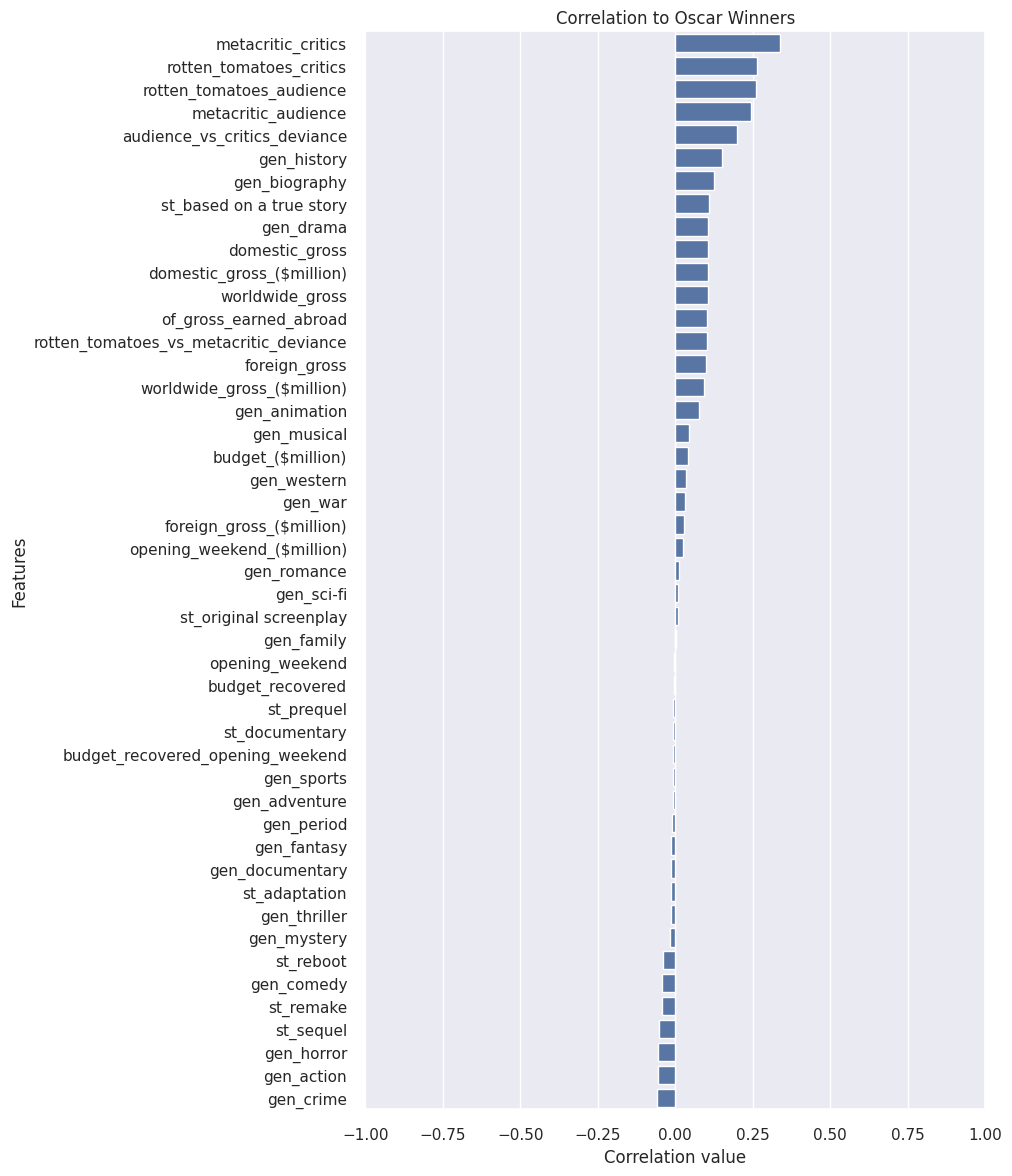

In [216]:
# remove non relevant columns
# df_cl_corr = df_cl.drop(['Film', 'Year','Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Release Date (US)','Oscar Detail'], axis=1)

# Remove non relevant columns and average critics columns
df_cl_corr = df_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail' , 'average_critics', 'average_audience'], axis=1)

# Calculate correlation values and grab last row
corr = df_cl_corr.corr()
last_row = pd.DataFrame(corr.iloc[-1, :-1]).sort_values(by='oscar_winners', ascending=False)

sns.set_theme()
plt.figure(figsize=(8, 14))
plt.title('Correlation to Oscar Winners')
plt.xlabel('Correlation value')
plt.ylabel('Features')
plt.xlim(-1, 1)
sns.barplot(data=last_row, x='oscar_winners', y=last_row.index)

### 3.2.2 Calculate VIF values to detect multicollinearity in features

In [217]:
# TODO: Strategy for dealing with high multicollinearity ?

# Drop labels from set
X = df_cl_corr.drop(['oscar_winners'], axis=1)
  
# VIF dataframe
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
vif_data["VIF"] = vif_data["VIF"].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# pd.options.display.float_format = '{:.2f}'.format
vif_data

/home/mike/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
33,rotten_tomatoes_vs_metacritic_deviance,inf
32,metacritic_audience,inf
31,rotten_tomatoes_audience,inf
29,rotten_tomatoes_critics,11201.77
30,metacritic_critics,10263.70
41,worldwide_gross,3548.80
34,audience_vs_critics_deviance,3465.94
40,foreign_gross,1601.11
37,domestic_gross,628.22
...,...,...


Remove high VIF variables and recalculate VIF

In [218]:
# df_cl_corr_reduced = df_cl_corr.drop(['Metacritic Audience ', 'Metacritic  critics', 'Audience vs Critics deviance ', 'Domestic Gross', ' Budget recovered opening weekend', 'Worldwide Gross ($million)','Foreign Gross'], axis=1)
# the independent variables set 
# df_cl_corr_reduced = df_cl_corr.drop(['oscar_winners', 'rotten_tomatoes_vs_metacritic_deviance', 'rotten_tomatoes_audience', 'worldwide_gross', ' Budget recovered opening weekend', 'Rotten Tomatoes Audience ', 'Domestic Gross', 'Metacritic  critics', 'Opening Weekend', 'Domestic gross ($million)'], axis=1)
# X = df_cl_corr_reduced
  
# # VIF dataframe 
# vif_data = pd.DataFrame() 
# vif_data["feature"] = X.columns 
  
# # calculating VIF for each feature 
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
# vif_data["VIF"] = vif_data["VIF"].round(2)
# vif_data = vif_data.sort_values(by='VIF', ascending=False)

# vif_data

### 3.2.3 Correlation Matrix
Remove low correlation values to oscar winners and plot correlation matrix to detext multicolinearity problems

Text(0.5, 1.0, 'Correlation Matrix')

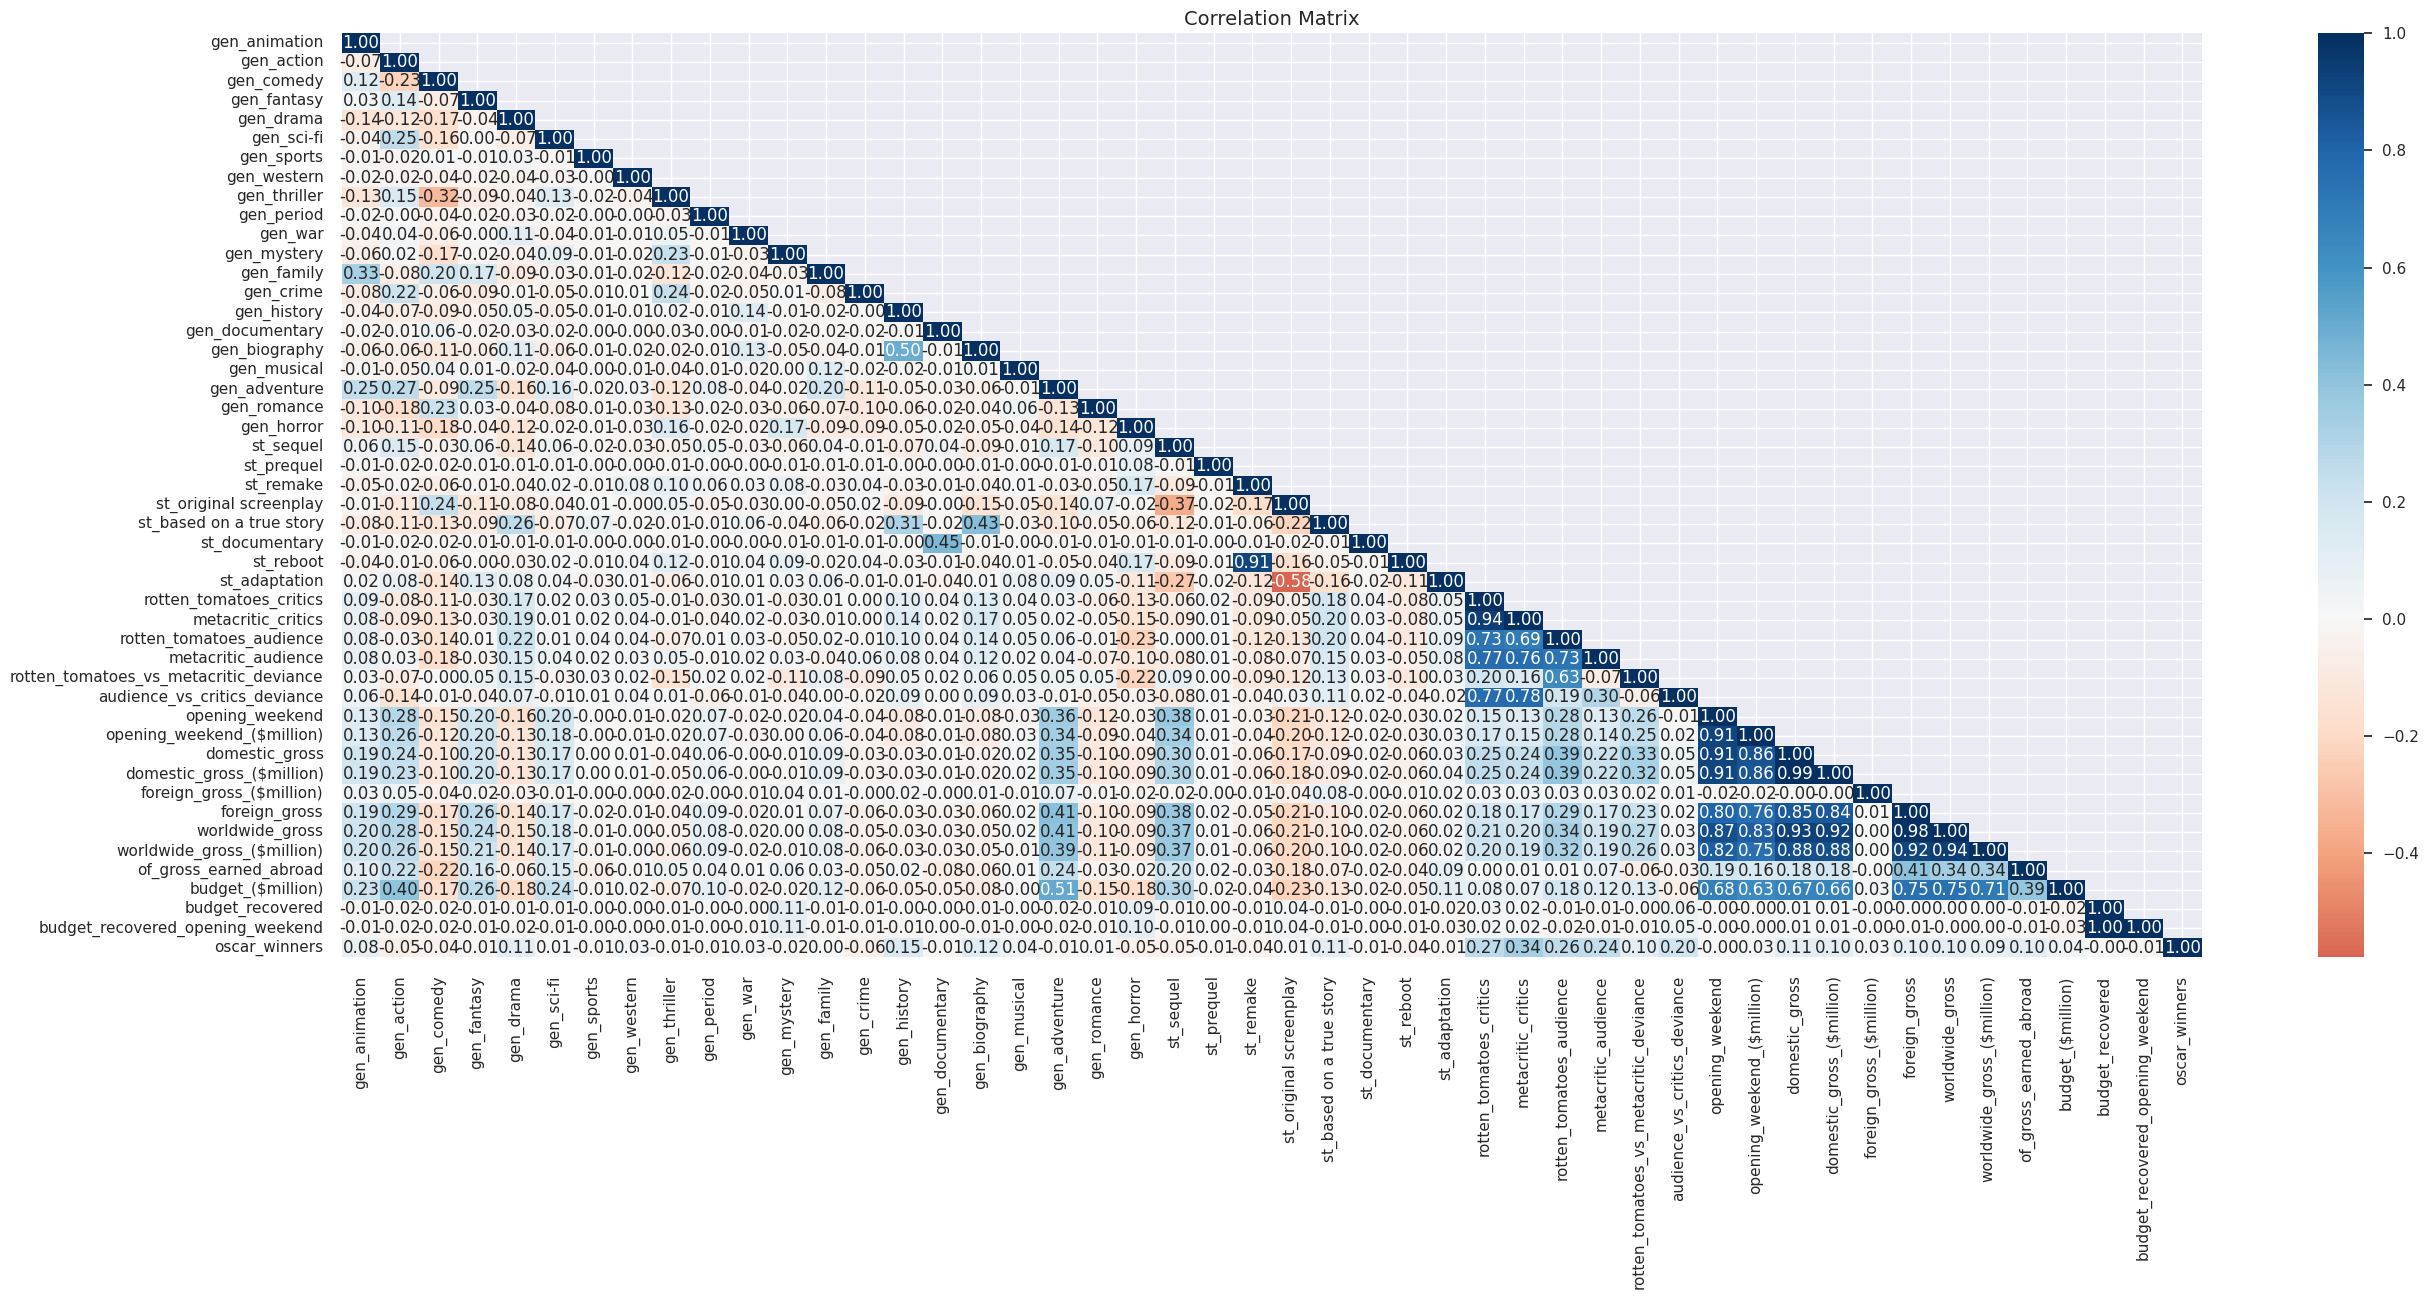

In [219]:
# Plot correlation matrix
# df_cl_corr_less = df_cl_corr[['Metacritic  critics', 'Rotten Tomatoes  critics','Rotten Tomatoes Audience ','Metacritic Audience ', 'Oscar Winners']]
df_cl_corr_less = df_cl_corr
corr_mat = df_cl_corr_less.corr()

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
plt.figure(figsize=(30, 12))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f')
plt.title('Correlation Matrix', fontsize=14)

#### Basic scatterplot of critics and audience scores

In [220]:
# sns.set_theme()
# # sns.set_style("whitegrid")
# fig, ax =plt.subplots(1,2)
# fig.set_figwidth(16)
# fig.set_figheight(6)
# ax[0].set_title('AVG critics vs AVG audience scores')
# ax[0].set_ylim(0, 100)
# ax[1].set_title('Budget vs Worlwide gross income ($millions)')
# sns.scatterplot(data=df_cl, x='average_critics', y='average_audience', hue='oscar_winners', ax=ax[0])
# sns.scatterplot(data=df_cl, x='budget_($million)', y='worldwide_gross_($million)', hue='oscar_winners', ax=ax[1])

In [221]:
# x = df_cl.drop(['Oscar Winners', 'Film', 'Year', 'Release Date (US)', 'Oscar Detail', 'Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Release Date (US)'], axis=1)
y = df_cl[['oscar_winners']]
meta = df_cl['film']

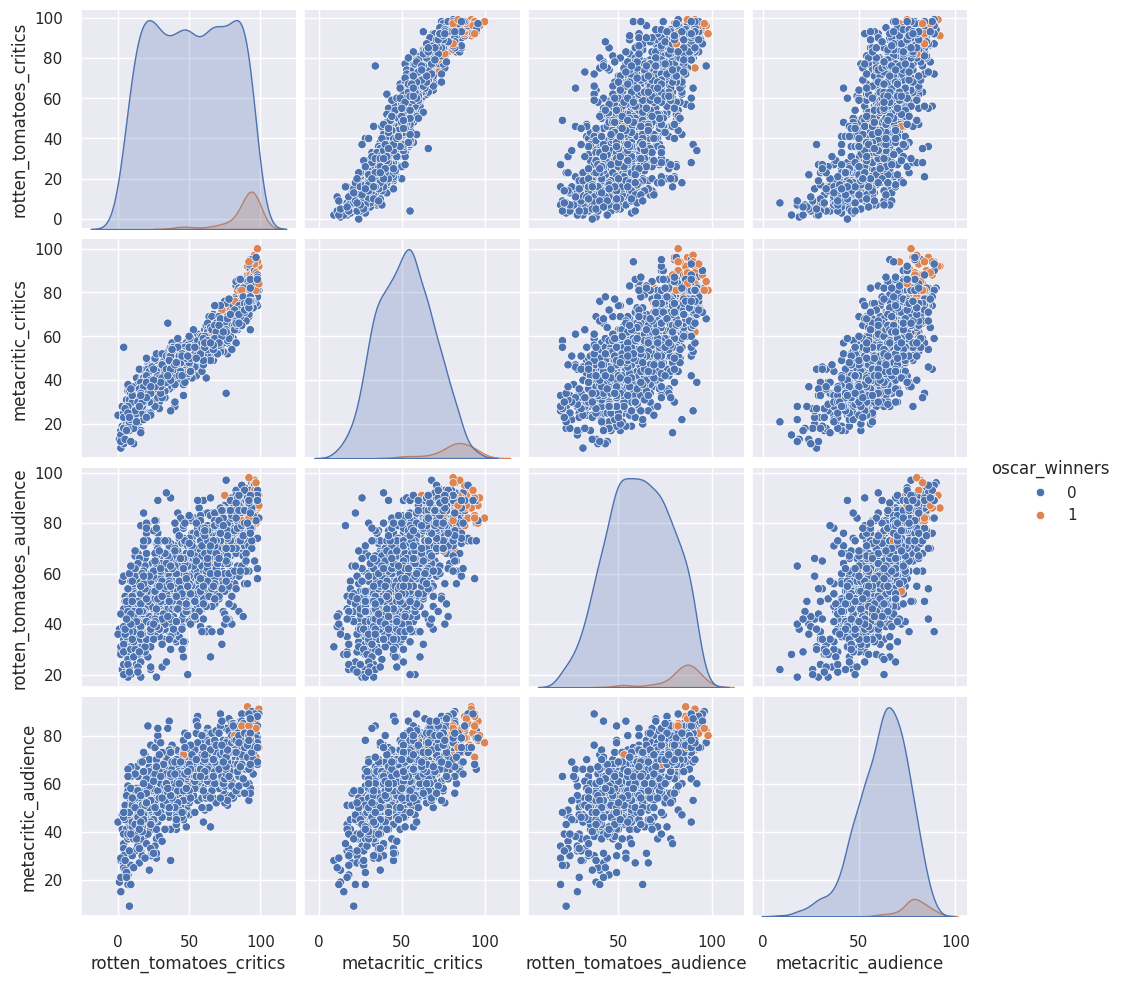

In [223]:
pairplt = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'rotten_tomatoes_audience', 'metacritic_audience']]
# plt.title('Pairplot')
sns.pairplot(pd.concat([pairplt, y], axis=1), hue='oscar_winners')

## 3.3 Principle Components Analysis

#### Calculate most important principal components

Text(0.5, 1.0, 'Scree plot')

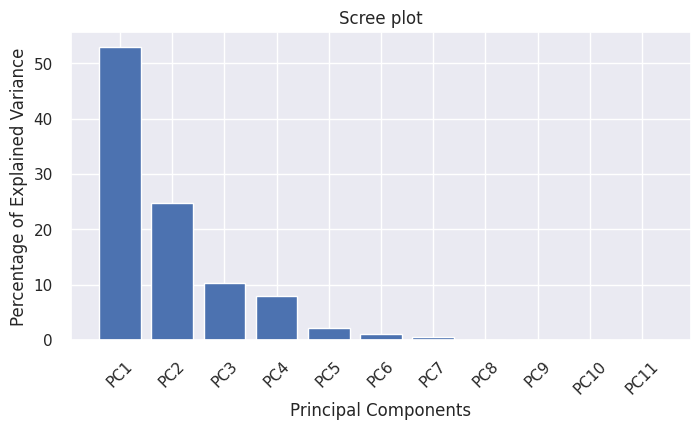

In [227]:
# Select features for PCA analysis
x = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience', 'metacritic_audience', 'average_audience', 'audience_vs_critics_deviance','domestic_gross', 'foreign_gross', 'worldwide_gross', 'of_gross_earned_abroad']]

# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(8,4))
plt.xticks(rotation=45)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')

Text(0, 0.5, 'Cumulative explanied variance')

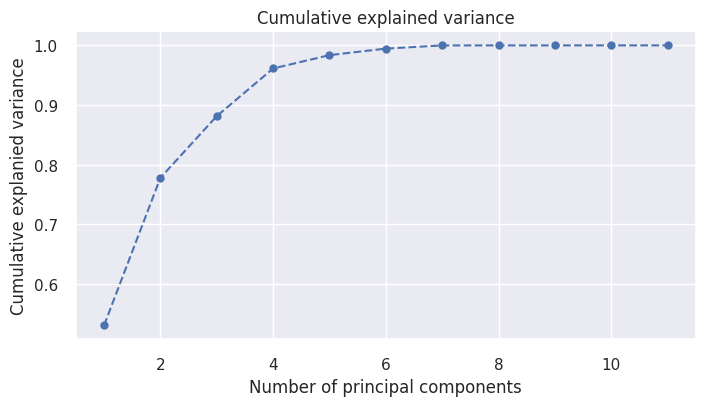

In [229]:
sns.set_theme()
plt.figure(figsize= (8,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')

<Axes: xlabel='PC1 - 53.02%', ylabel='PC2 - 24.76%'>

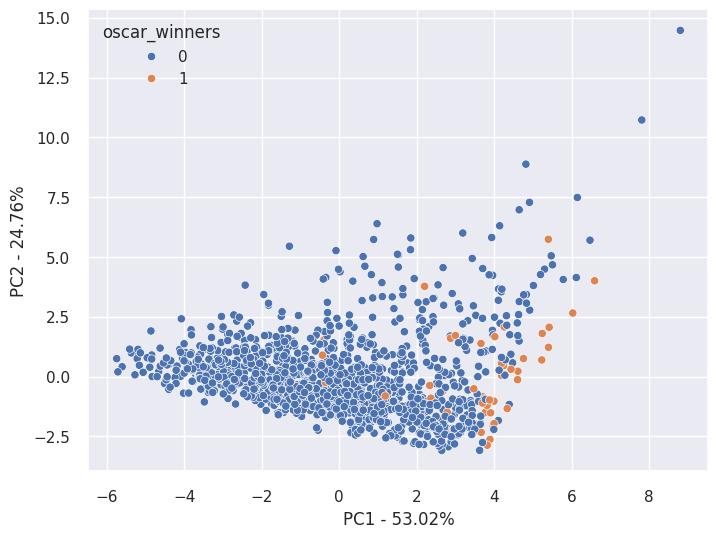

In [231]:
sns.set_theme()
plt.figure(figsize=(8, 6))
plt.xlabel(f'PC1 - {per_var[0]}%')
plt.ylabel(f'PC2 - {per_var[1]}%')
sns.scatterplot(data=final_df, x="PC1", y='PC2', hue='oscar_winners')

#### Recalculating PCA with most important principal components

In [232]:
pca = PCA(n_components=4)
principal_components = pca.fit_transform(x)

## 3.4 Clustering

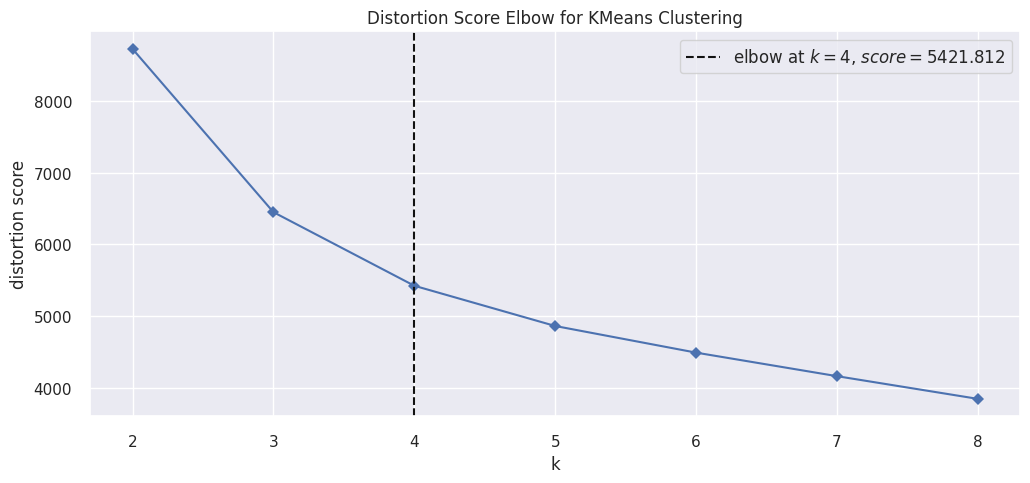

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [233]:
# Set plot style, and background color
sns.set_theme()
# sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
# sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=42)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=8, timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(principal_components)

# Finalize and render the figure
visualizer.show()

In [234]:
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.head()

,0,1,2,3
0,1.681184,1.878610,-1.748924,-0.141346
1,2.632567,-1.942094,-0.414276,-0.698131
2,-0.431365,-0.665775,0.029975,0.202199
3,0.512520,-1.265782,-2.167283,-0.587150
4,-3.631595,0.891980,0.941894,0.624355


In [235]:
N_CLUSTERS = 4

# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans.fit(principal_components_df)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)
print(cluster_frequencies)
# for item in cluster_frequencies:
#     print(item)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {0: 0, 1: 1, 2: 2, 3: 3}.items()}
# label_mapping = {v: k for k, v in {0: 0, 1: 1, 2: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
# customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
principal_components_df = pd.concat([principal_components_df, y], axis = 1)

principal_components_df['cluster'] = new_labels



Counter({2: 470, 1: 373, 3: 359, 0: 131})


In [236]:
cluster_dict = {}

for i in range(len(label_mapping)):
    cluster_dict[i] = 0

for item in principal_components_df.values:
    if item[-2] == 1:
        cluster_dict[item[-1]] = cluster_dict[item[-1]] +1
print(cluster_dict)

{0: 14, 1: 0, 2: 3, 3: 37}


<BarContainer object of 4 artists>

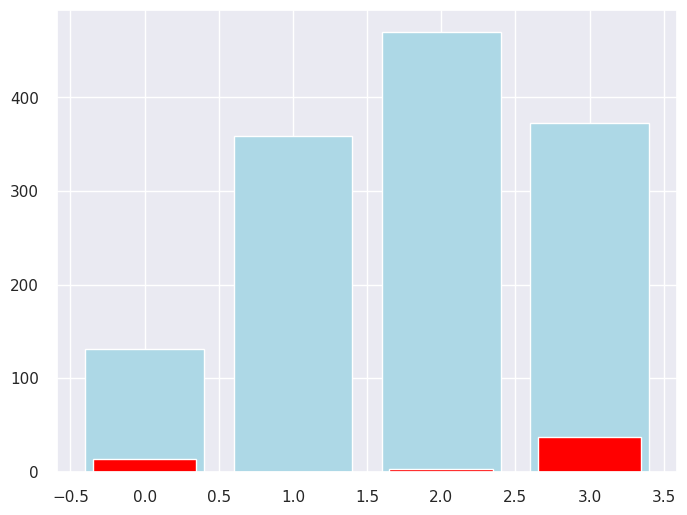

In [237]:
labels = []
for item in set(kmeans.labels_):
    labels.append(item)

numbers = []
for key in cluster_frequencies:
     numbers.append(cluster_frequencies[key])

oscar = []
for key in cluster_dict:
     oscar.append(cluster_dict[key])
     
sns.set_theme()
plt.figure(figsize=(8,6))
plt.bar(labels, numbers, color='lightblue')
plt.bar(labels, oscar, width=0.7, color='red')

# 4. Prediction models

## 4.1 Neural Network classification model

### 4.1.1 Prepare dataset
Feature selection

In [238]:
# remove unecessesary features from dataset
# df = df.drop(['Film','Year','Script Type','Opening Weekend', 'Domestic Gross', 'Foreign Gross', 'Worldwide Gross', 'Rotten Tomatoes vs Metacritic  deviance', 'Audience vs Critics deviance ', 'Worldwide Gross ($million)', ' of Gross earned abroad', 'Average audience ', 'Average critics ', ' Budget recovered', ' Budget recovered opening weekend'], axis=1)
df_nn = df[['rotten_tomatoes_critics', 'metacritic_critics', 'rotten_tomatoes_audience', 'metacritic_audience', 'oscar_winners']]

#### Balance classes

In [239]:
# Select all oscar winning movies
df_oscar_winners = df_nn[df_nn['oscar_winners'] == 1]

# Pick a random subset from non oscar winning movies
df_no_oscar_winners = df_nn[df_nn['oscar_winners'] == 0].sample(len(df_oscar_winners) * 2)

frames = [df_oscar_winners, df_no_oscar_winners]

df_nn = pd.concat(frames)
df_nn = df_nn.sample(frac=1) # Shuffle rows

#### Training and testing splits

In [240]:
# Train test split with stratify
features = df_nn.drop(['oscar_winners'], axis=1)
labels = df_nn['oscar_winners']

X = torch.from_numpy(features.to_numpy(dtype='float32'))
y = torch.from_numpy(labels.to_numpy(dtype='float32')).unsqueeze(dim=1)

print(f'Shapes: X: {X.shape}, y: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Shapes: X: torch.Size([162, 4]), y: torch.Size([162, 1])


In [241]:
# Check stratification (FOR DEBUGGING. WILL BE REMOVED LATER)
train = 0
for item in y_train:
    if item.item() == 1:
        train += 1

test = 0
for item in y_test:
    if item.item() == 1:
        test += 1

print(f'Oscar winners in training labels: {train}\nOscar winners in testing labels: {test}')

Oscar winners in training labels: 38
Oscar winners in testing labels: 16


In [242]:
# Check tensor dtypes FOR DEBUGGING
print(f'Check tensors data types:\n{X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype}')

Check tensors data types:
(torch.float32, torch.float32, torch.float32, torch.float32)


### 4.1.2 Define PyTorch classes and functions

#### Define NN Classification model

In [243]:
class OscarClassification(nn.Module):
    def __init__(self, input_features: int, output_features: int):
        super(OscarClassification, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=output_features)
        )

    # Not using sigmoid here when use BCEWithLogits loss function
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

#### Define train and test functions

In [244]:
def train(model, loss_fn, optimizer, accuracy_fn, X_train, y_train, X_test, y_test, epochs, device, seed=None, verbose=False):
    if seed != None:
        torch.manual_seed(seed)

    epochs = epochs
    
    X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)
    
    model.train()

    # for epoch in tqdm(range(epochs), desc='Training...'):
    for epoch in range(epochs):
        y_pred = model(X_train).to(device)

        loss = loss_fn(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate prediction accuracy
        y_train_pred = torch.round(torch.sigmoid(y_pred))
        acc = accuracy_fn(y_pred=y_train_pred, y_true=y_train)

        if verbose:
        ### Testing
            model.eval()
            with torch.inference_mode():
                y_pred_test = model(X_test)
                test_loss = loss_fn(y_pred_test, y_test)
                test_acc = accuracy_fn(y_pred=torch.round(torch.sigmoid(y_pred_test)), y_true=y_test)

            if epoch % int(epochs/10) == 0 or epoch == epochs-1:
                print(f'Epoch: {epoch:04d} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
            
    return acc

In [245]:
def test(model, accuracy_fn, X_test, y_test, device):
    with torch.inference_mode():
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_test_logits = model(X_test)
        y_test_probs = torch.sigmoid(y_test_logits)
        acc = accuracy_fn(y_pred=torch.round(y_test_probs), y_true=y_test)
    print(f'Test total accuracy: {acc:.2f}%')
    return y_test_probs, acc

#### Define loss function and set device

In [246]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f'Device used: {device}')

# Initialize model
# model = OscarClassification(input_features=X_train.shape[1], output_features=1).to(device)

# Loss function
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)

# Optimizer functions
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# optimizer= torch.optim.Adam(model.parameters(), lr=0.01)

Device used: cuda


#### Define helper functions

In [247]:
# Accuracy calculator helper function
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

### 4.2.2 Train NN model

Train models multiple times and calculate average accuracy for specific models

In [248]:
results = []
for i in tqdm(range(10)):
    # Initialize model and optimizer
    model = OscarClassification(input_features=X_train.shape[1], output_features=1).to(device)
    n_params = sum(p.numel() for p in model.parameters())
    optimizer= torch.optim.Adam(model.parameters(), lr=0.01)
    train(model, loss_fn, optimizer, accuracy_fn, X_train, y_train, X_test, y_test, 400, device, seed=None, verbose=False)
    y_pred, acc = test(model, accuracy_fn, X_test, y_test, device)
    # correct_oscar_guesses = count_oscars(y_pred, y_test)
    results.append({'model' : 'model_in-10-10-ep400', 
                    'model_params' : n_params, 
                    'accuracy' : acc, 
                    'preds' : y_pred.to('cpu').numpy(), 
                    'pred_oscar_count' : int(y_pred.sum().item()), 
                    'truth_oscar_count' : int(y_test.sum().item()) })

  0%|          | 0/10 [00:00<?, ?it/s]

Test total accuracy: 87.76%
Test total accuracy: 87.76%
Test total accuracy: 87.76%
Test total accuracy: 89.80%
Test total accuracy: 87.76%
Test total accuracy: 91.84%
Test total accuracy: 85.71%
Test total accuracy: 91.84%
Test total accuracy: 87.76%
Test total accuracy: 93.88%


#### Test accuracy on whole dataset

In [51]:
#TODO: above 

### 4.2.3 Result evaluations for best performing neural network model

In [52]:
best = max(results, key=lambda x:x['accuracy'])

#### AUC Curve

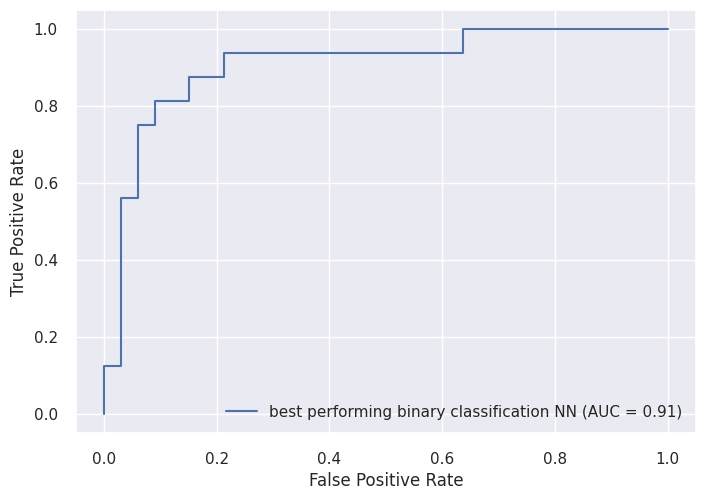

In [53]:
y_true = y_test.to('cpu').numpy().flatten()
y_pred = best['preds'].flatten()

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='best performing binary classification NN')
display.plot()
plt.show()

In [54]:
y_test, y_test_pred = y_test.to('cpu'), torch.round(torch.tensor((best['preds'])))
cf_matrix = confusion_matrix(y_test, y_test_pred)
print(cf_matrix)
print('\n')
print(classification_report(y_test, y_test_pred))

[[30  3]
 [ 3 13]]


              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91        33
         1.0       0.81      0.81      0.81        16

    accuracy                           0.88        49
   macro avg       0.86      0.86      0.86        49
weighted avg       0.88      0.88      0.88        49



#### Visualize metrics

<Axes: >

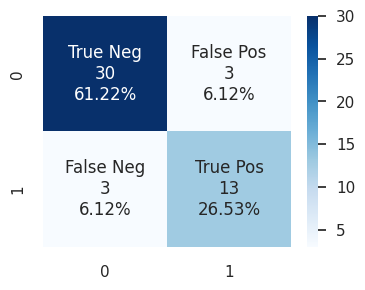

In [55]:
sns.set()
group_names = ['True Neg','False Pos','False Neg','True Pos']               
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(4, 3))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [56]:
pd.DataFrame(data=classification_report(y_test, y_test_pred, output_dict=True)).T

,precision,recall,f1-score,support
0.0,0.909091,0.909091,0.909091,33.000000
1.0,0.812500,0.812500,0.812500,16.000000
accuracy,0.877551,0.877551,0.877551,0.877551
macro avg,0.860795,0.860795,0.860795,49.000000
weighted avg,0.877551,0.877551,0.877551,49.000000


## 4.3 K-Nearest Neighbors classification model

In [57]:
df_knn = df_cl[['Rotten Tomatoes  critics', 'Metacritic  critics',
       'Rotten Tomatoes Audience ', 'Metacritic Audience ',
       'Opening weekend ($million)', 'Domestic gross ($million)',
       'Foreign Gross ($million)', 'Budget ($million)', 'Oscar Winners']]

In [58]:
df_knn.columns

Index(['Rotten Tomatoes  critics', 'Metacritic  critics',
       'Rotten Tomatoes Audience ', 'Metacritic Audience ',
       'Opening weekend ($million)', 'Domestic gross ($million)',
       'Foreign Gross ($million)', 'Budget ($million)', 'Oscar Winners'],
      dtype='object')

In [59]:
df_oscar_winners = df_knn[df_knn["Oscar Winners"] == 1]
print(df_oscar_winners.shape)

df_rest = df_knn[df_knn["Oscar Winners"] != 1]
df_rest = df_rest.sample(n=55, random_state=42)
print(df_rest.shape)

df_small = pd.concat([df_oscar_winners, df_rest], axis=0)
print(df_small.shape)

(54, 9)
(55, 9)
(109, 9)


In [60]:
X_knn = df_small.iloc[:, :-1].values
y_knn = df_small.iloc[:, -1].values

In [61]:
y_knn = y_knn.astype(str)

In [62]:
for index, label in enumerate(y_knn):
    if label == '1.0':
        y_knn[index] = 'Winner'
    elif label == '0.0':
        y_knn[index] = 'Not winner'

In [63]:
X_knn.shape, y_knn

((109, 8),
 array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
        '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
        '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
        '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
        '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0'], dtype='<U21'))

In [64]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_knn, y_knn, test_size=0.2, stratify=y_knn, random_state=42)

In [65]:
scaler = StandardScaler()

scaler.fit(X_train_knn)
X_train_knn = scaler.transform(X_train_knn)

X_test_knn = scaler.transform(X_test_knn)

In [66]:
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_knn, y_knn, cv=5)
    scores.append(np.mean(score))

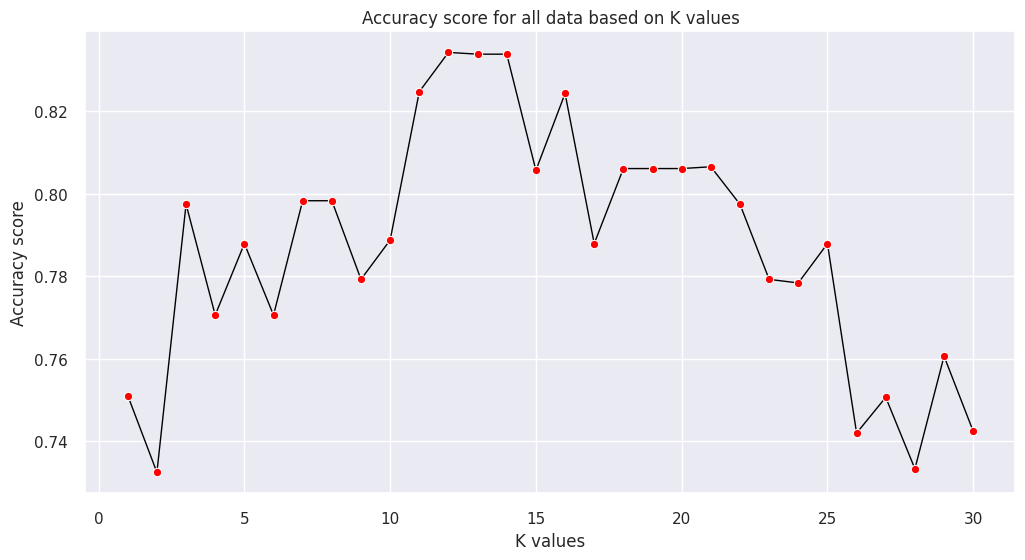

In [67]:
plt.figure(figsize=(12,6))
sns.lineplot(x = k_values, y = scores, marker='o', markerfacecolor='red', color='black', linewidth=1).set(title='Accuracy score for all data based on K values',
                                                                                       xlabel='K values',
                                                                                       ylabel='Accuracy score')
sns.set_theme(style='darkgrid', font_scale=1.25)
# sns.set(rc={'figure.facecolor':'lightgrey'})

In [68]:
best_index = np.argmax(scores)
best_k = k_values[best_index]
best_k

12

In [69]:
K = []
training = []
test = []
scores = {}

for k in range(1, 31):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train_knn, y_train_knn)

    training_score = clf.score(X_train_knn, y_train_knn)
    test_score = clf.score(X_test_knn, y_test_knn)
    K.append(k)

    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]

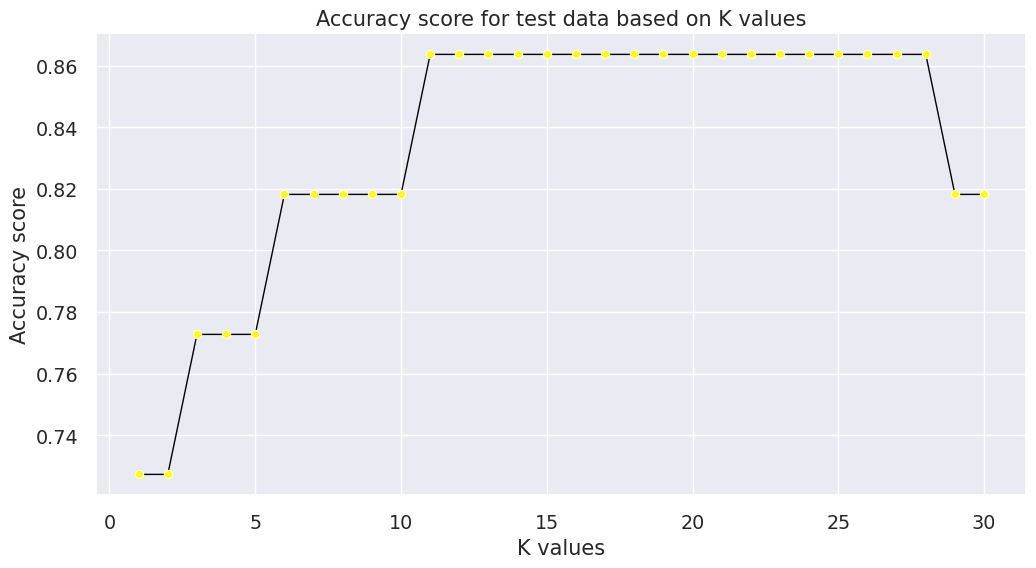

In [70]:
plt.figure(figsize=(12,6))
sns.lineplot(x = K, y = test, marker='o', markerfacecolor='yellow', color='black', linewidth=1).set(title='Accuracy score for test data based on K values',
                                                                                                              xlabel='K values',
                                                                                                              ylabel='Accuracy score')
sns.set_theme(style='darkgrid', font_scale=1.25)

In [71]:
best_index = np.argmax(scores)
best_k = k_values[best_index]
best_k

1

In [72]:
classifier_small = KNeighborsClassifier(n_neighbors=14)
classifier_small.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(n_neighbors=14)

In [73]:
y_preds_small = classifier_small.predict(X_test_knn)

In [74]:
from sklearn.metrics import classification_report, confusion_matrix

In [75]:
print(classification_report(y_test_knn, y_preds_small))
print(confusion_matrix(y_test_knn, y_preds_small))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.83      0.91      0.87        11

    accuracy                           0.86        22
   macro avg       0.87      0.86      0.86        22
weighted avg       0.87      0.86      0.86        22

[[ 9  2]
 [ 1 10]]


## 4.4 Model comparisson graphs
- TODO: Plot AUC curves for best performing experiment of each model
- TODO: Plot Average score (accuracy / correct oscar guesses) achieved for each type of model
- TODO: Plot based on confusion matric values

<Axes: >

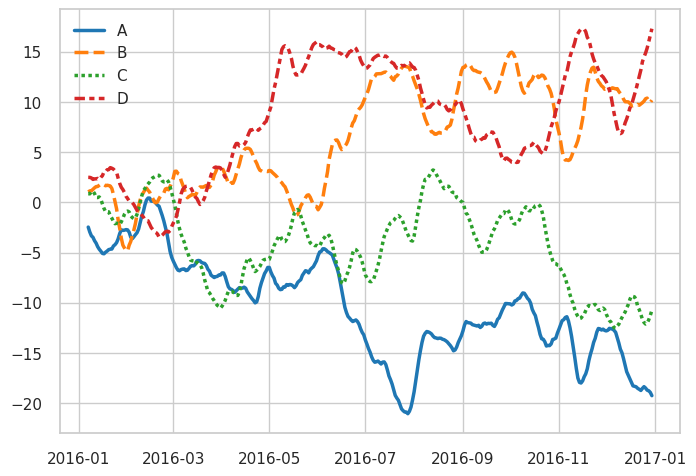

In [76]:
# Placeholder graph
sns.set_theme(style="whitegrid")

rs = np.random.RandomState(365)
values = rs.randn(365, 4).cumsum(axis=0)
dates = pd.date_range("1 1 2016", periods=365, freq="D")
data = pd.DataFrame(values, dates, columns=["A", "B", "C", "D"])
data = data.rolling(7).mean()

sns.lineplot(data=data, palette="tab10", linewidth=2.5)